### Goal: Membuat Model Clustering untuk mengkategorikan pelanggan ke dalam beberapa cluster

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

In [40]:
df = pd.read_csv('~/kode/python/mini_project/indosat_dashboard/data_pelanggan_indosat.csv')
df.head()

,Nama,No_HP,Kota,Paket,Tgl_beli,Durasi_Bulan,Frekuensi_Topup,Kuota_Bulan_GB
0,"Balidin Dongoran, S.T.",85799239640,Surabaya,Freedom Combo,2024-10-08,9,5,16
1,Okto Jailani,81478074443,Jakarta,Freedom Combo,2025-03-15,4,1,7
2,R. Lantar Anggraini,81462526817,Medan,Freedom Combo,2024-07-22,12,2,20
3,Darimin Pradipta,81443713796,Semarang,Unlimited 2GB,2025-01-11,2,3,5
4,Kanda Napitupulu,85669303428,Surabaya,Yellow,2025-03-30,12,1,1


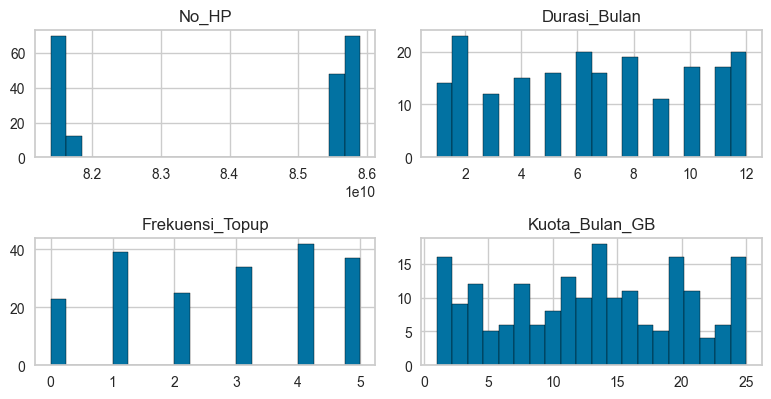

In [41]:
numeric_features = df.select_dtypes(include='number').columns

fig, axes = plt.subplots(3, 2, figsize=(8, 6))
axes = axes.flatten()

for i, column in enumerate(df[numeric_features].columns):
  df[numeric_features][column].hist(ax=axes[i], bins=20, edgecolor='black')
  axes[i].set_title(column)

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [42]:
# scaling using standardization, karena data terdistribusi normal
std_scale = StandardScaler()
df[numeric_features] = std_scale.fit_transform(df[numeric_features])

df.head()

,Nama,No_HP,Kota,Paket,Tgl_beli,Durasi_Bulan,Frekuensi_Topup,Kuota_Bulan_GB
0,"Balidin Dongoran, S.T.",0.873539,Surabaya,Freedom Combo,2024-10-08,0.692458,1.359747,0.448111
1,Okto Jailani,-1.219428,Jakarta,Freedom Combo,2025-03-15,-0.738240,-1.025774,-0.830177
2,R. Lantar Anggraini,-1.226958,Medan,Freedom Combo,2024-07-22,1.550877,-0.429394,1.016239
3,Darimin Pradipta,-1.236070,Semarang,Unlimited 2GB,2025-01-11,-1.310520,0.166986,-1.114241
4,Kanda Napitupulu,0.810604,Surabaya,Yellow,2025-03-30,1.550877,-1.025774,-1.682369


In [43]:
# ubah fitur kategori menjadi numerik dengan LabelEncoder
kategori_features = df.select_dtypes(include='object').columns
encoders = {}
df_temp = df.copy()

for feature in kategori_features:
    le = LabelEncoder()
    df_temp[feature] = le.fit_transform(df[feature])
    encoders[feature] = le

df = df_temp
df.head()

,Nama,No_HP,Kota,Paket,Tgl_beli,Durasi_Bulan,Frekuensi_Topup,Kuota_Bulan_GB
0,11,0.873539,5,0,44,0.692458,1.359747,0.448111
1,115,-1.219428,1,0,108,-0.738240,-1.025774,-0.830177
2,138,-1.226958,3,0,2,1.550877,-0.429394,1.016239
3,23,-1.236070,4,2,86,-1.310520,0.166986,-1.114241
4,88,0.810604,5,4,114,1.550877,-1.025774,-1.682369


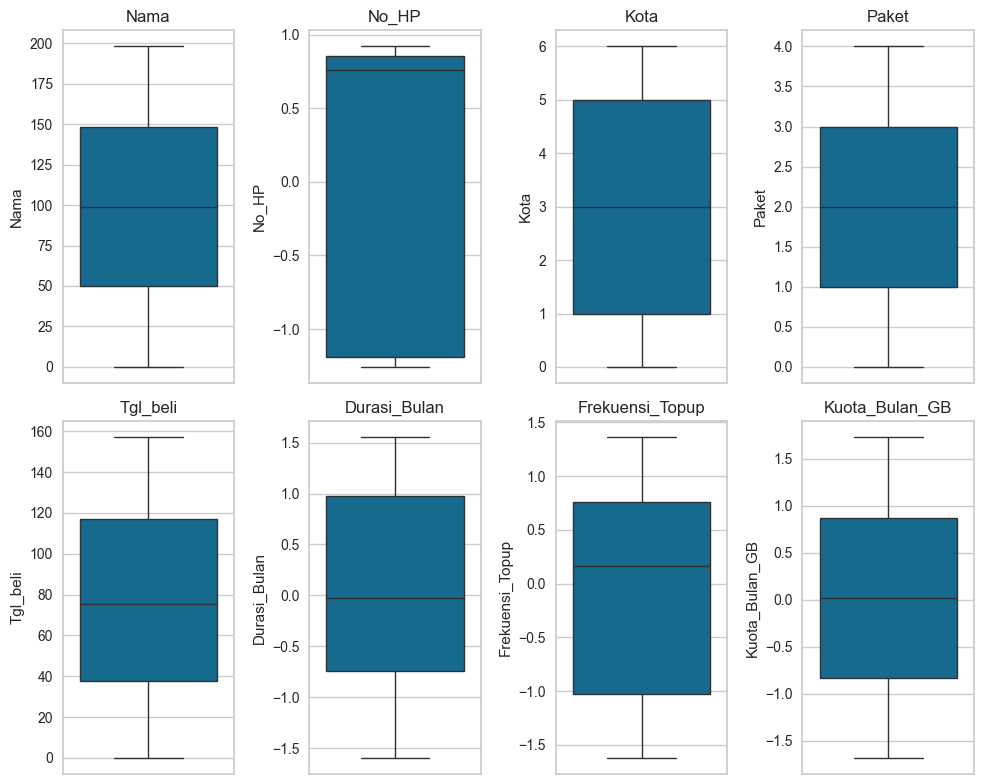

In [44]:

# Melakukan Handling Outlier Data berdasarkan jumlah outlier, apakah menggunakan metode drop atau mengisi nilai tersebut.
for feature in df[numeric_features].columns:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # tangani outlier dengan median
    median = df[feature].median()
    df.loc[:, feature] = df[feature].apply(lambda x: median if x < lower or x > upper else x)

# visualisasikan
cols = 4
fig, axes = plt.subplots(2, cols, figsize=(10, 8))

for i, feature in enumerate(df.columns):
    baris, kolom = divmod(i, cols)
    sns.boxplot(y=df[feature], ax=axes[baris, kolom])
    axes[baris, kolom].set_title(f'{feature}')

plt.tight_layout()
plt.show()

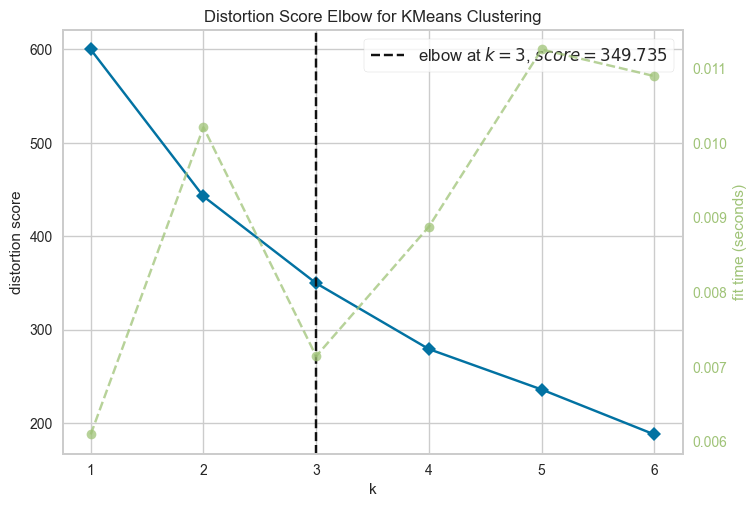

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
# Melakukan visualisasi Elbow Method menggunakan KElbowVisualizer()
cluster_features = df[['Durasi_Bulan', 'Kuota_Bulan_GB', 'Frekuensi_Topup']]
kmeans_elbow = KMeans(random_state=42)
kelbow_visual = KElbowVisualizer(kmeans_elbow, k=(1, 7))
kelbow_visual.fit(cluster_features)

kelbow_visual.show()

In [46]:
# Menggunakan algoritma K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(cluster_features)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [47]:
# Menghitung dan menampilkan nilai Silhouette Score.
silhouette_score(cluster_features, kmeans.fit_predict(cluster_features))

0.2413538505054932

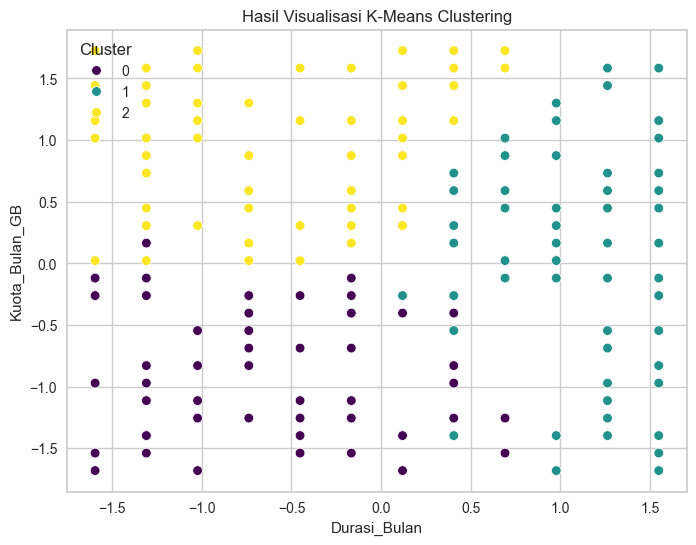

In [48]:

# Membuat visualisasi hasil clustering
df['Cluster'] = kmeans.labels_
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Durasi_Bulan', y='Kuota_Bulan_GB', hue='Cluster', palette='viridis')
plt.title('Hasil Visualisasi K-Means Clustering')
plt.xlabel('Durasi_Bulan')
plt.ylabel('Kuota_Bulan_GB')
plt.show()


In [49]:
# inverse dataset
df[numeric_features] = std_scale.inverse_transform(df[numeric_features])

for feature in kategori_features:
    df[feature] = encoders[feature].inverse_transform(df[feature].astype(int))

df.head()

,Nama,No_HP,Kota,Paket,Tgl_beli,Durasi_Bulan,Frekuensi_Topup,Kuota_Bulan_GB,Cluster
0,"Balidin Dongoran, S.T.",8.579924e+10,Surabaya,Freedom Combo,2024-10-08,9.0,5.0,16.0,1
1,Okto Jailani,8.147807e+10,Jakarta,Freedom Combo,2025-03-15,4.0,1.0,7.0,0
2,R. Lantar Anggraini,8.146253e+10,Medan,Freedom Combo,2024-07-22,12.0,2.0,20.0,1
3,Darimin Pradipta,8.144371e+10,Semarang,Unlimited 2GB,2025-01-11,2.0,3.0,5.0,0
4,Kanda Napitupulu,8.566930e+10,Surabaya,Yellow,2025-03-30,12.0,1.0,1.0,1


In [50]:
# descriptive features

descriptive_features = ['Durasi_Bulan', 'Frekuensi_Topup', 'Kuota_Bulan_GB']
descriptive_features_categorical = ['Kota', 'Paket']

agg_result = df.groupby('Cluster')[descriptive_features].agg(['mean', 'min', 'max', 'count'])
agg_result_categorical = df.groupby('Cluster')[descriptive_features_categorical].agg(pd.Series.mode)

display(agg_result)
display(agg_result_categorical)

Durasi_Bulan                  Frekuensi_Topup                  \
                mean  min   max count            mean  min  max count   
Cluster                                                                 
0           4.441176  1.0  10.0    68        2.176471  0.0  5.0    68   
1          10.333333  7.0  12.0    72        2.902778  0.0  5.0    72   
2           4.500000  1.0   9.0    60        3.116667  0.0  5.0    60   

        Kuota_Bulan_GB                    
                  mean   min   max count  
Cluster                                   
0             6.705882   1.0  15.0    68  
1            12.902778   1.0  24.0    72  
2            19.733333  13.0  25.0    60

,Kota,Paket
Cluster,,
0,Yogyakarta,Unlimited 2GB
1,Surabaya,Freedom Internet
2,"[Bandung, Semarang]",Freedom Internet


## Interpretasi Hasil Cluster
### Cluster 0:
- ***68 Customer***
- ***rata-rata Kuota_Bulan_GB = 6GB***
- ***dominasi Kota = Yogyakarta***
- ***dominasi Paket = Unlimited 2GB***
- Pada rentang cluster ini jumlah pengguna terbanyak di dominasi oleh wilayah Yogyakarta, dengan pengguna sebanyak 68 dari total 200 orang. Untuk paket yang paling populer di cluster ini adalah Unlimited 2GB dengan penggunaan rata-rata menyentuh angka 6GB per bulan.

### Cluster 1:
- ***72 Customer***
- ***rata-rata Kuota_Bulan_GB = 12GB***
- ***dominasi Kota = Surabaya***
- ***dominasi Paket = Freedom Internet***
- Cluster ini memiliki total pengguna terbanyak yaitu 72 orang, dengan kebanyakan pengguna berasal dari Kota Surabaya. Paket Freedom Internet merupakan jenis paket yang paling banyak dibeli oleh customer dalam cluster ini dengan rata-rata penggunaan tiap bulan mencapai 12GB per bulan.

### Cluster 2:
- ***60 Customer***
- ***rata-rata Kuota_Bulan_GB = 19GB***
- ***dominasi Kota = Bandung, Semarang***
- ***dominasi Paket = Freedom Internet***
- Lagi-lagi paket Freedom Internet adalah pilihan populer bagi orang-orang yang berada pada cluster ini, dengan pengguna sebanyak 60 orang yang berasal dari wilayah Bandung dan Semarang. Rata-rata pengguna menghabiskan kuota sebanyak 19GB tiap bulan.

### Kesimpulan Akhir:
Dari pengelompokan yang sudah dilakukan, terlihat bahwa Paket Freedom Internet merupakan pilihan utama bagi sebagian besar customer dengan total pengguna terbanyak berada di wilayah Surabaya, Bandung dan Semarang.